# Purpose and Objectives:

Welcome! In this notebook, we will be covering the basics of autoencoder architectures, in particular the (vanilla) autoencoder and the variatonal autoencoder architectures. Throughout the notebook, there will be a set of concept check questions. You can find the corresponding question in our supplemental conceptual document.

After completing this notebook, you will:


1.   Have a complete understanding of the general AE and VAE architectures
2.   Be able to implemting AEs and VAEs in Pytorch
3.   Evaluate the models' performance (loss/accuracy), denoising ability, and latent space through visualizations

*Note: It may be a good idea to review the basic principles of PCA as they will be referred to throughout the project*

## The Fundamental Setup of Autoencoder Architectures:

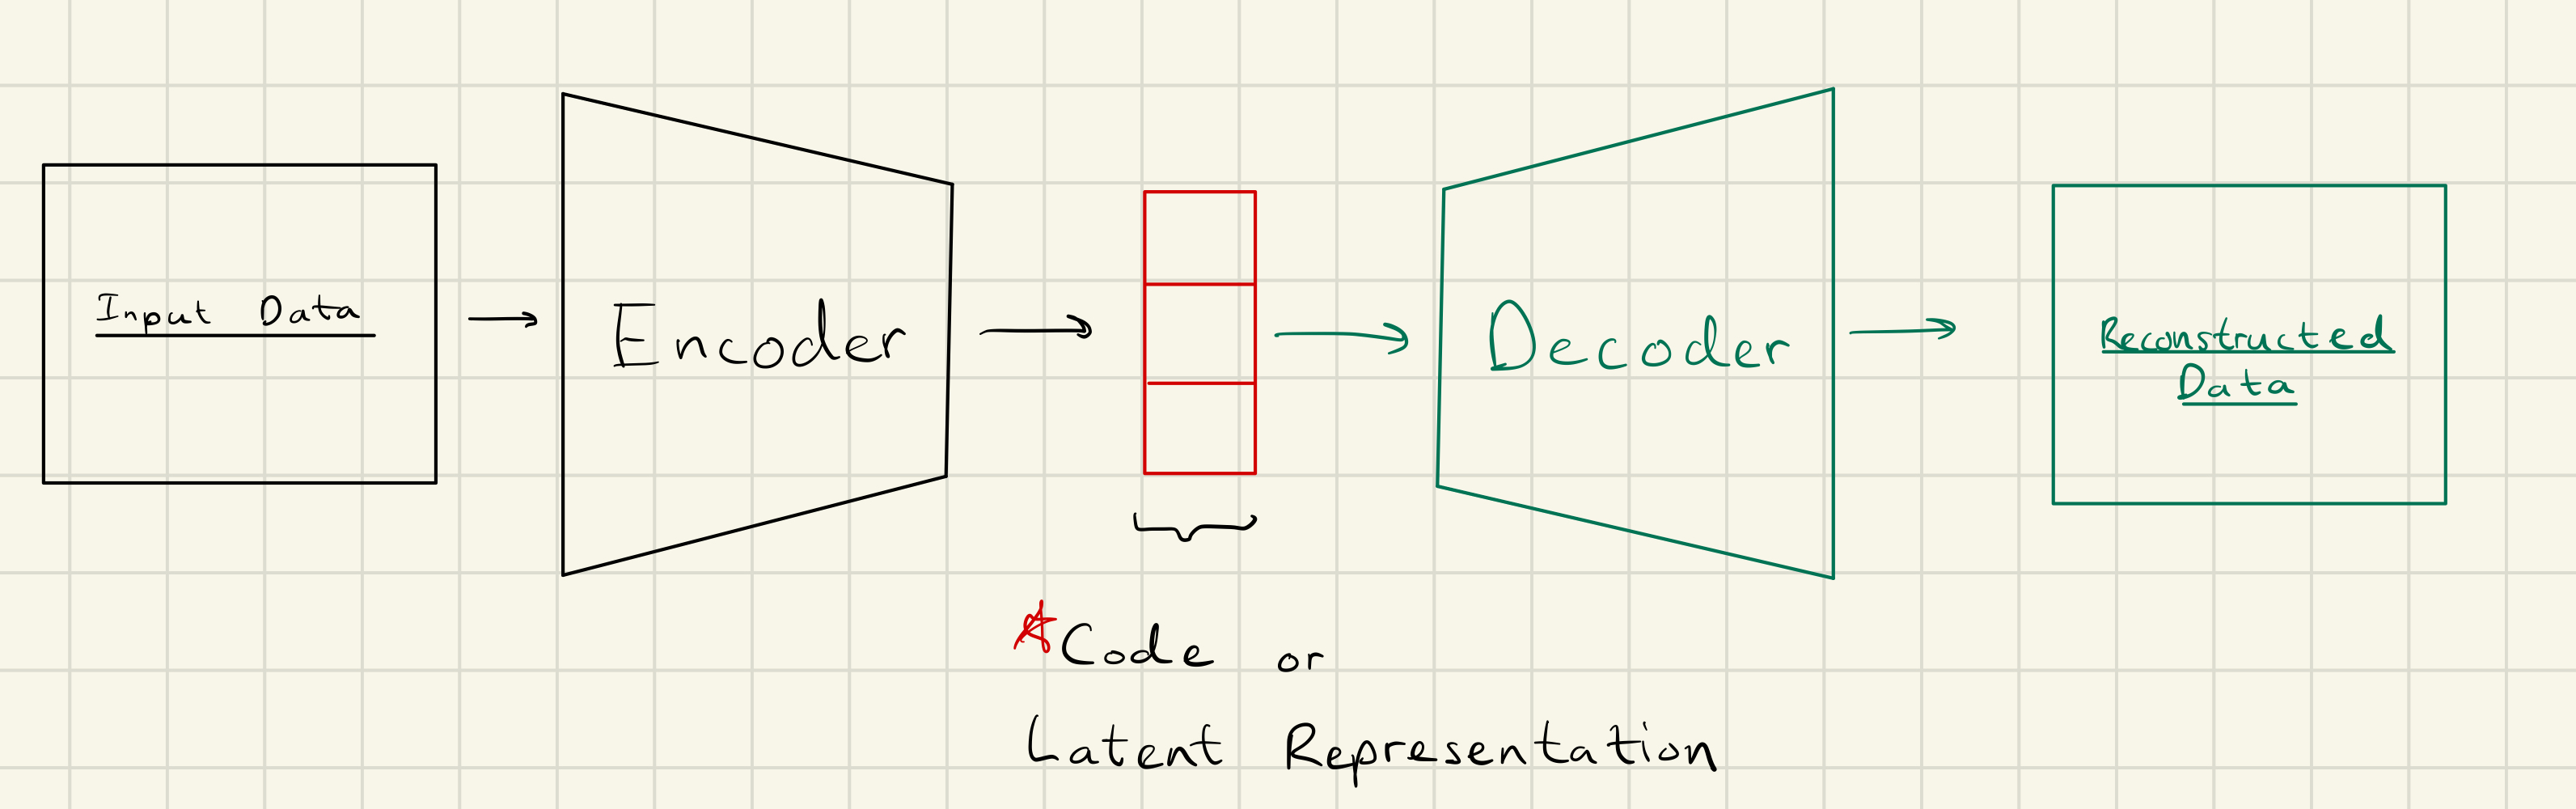

The above diagram represents the foundational architecture structure of autoencoders, especially the (Vanilla) Autoencoder. As referenced in Hinton et. al., the purpose of autoencoders aligns very much with the motivations of PCA. One can consider the encoder to be a mapping from the high dimensional space of the input to the low-dimensional space of the latent representation. Similarly, the decoder *reconstructs* the low-dimensional represntation back into the original dimensionality. We discuss the purposes of this architecture in the next section.

### Concept Check 1.1.1

## Why Autoencoder Architectures? (Note to self: add images and figures later)

Autoencoder-style models have many different uses. We list several of the most notable ones here:

1.   **Dimensionality Reduction:** As mentioned in Hinton et. al., the *main* motivation for the AE architecutere is to turn "high-dimensional data" into "low dimensional codes". Adopting from the spirit of PCA, the encoder of an autoencoder can be thought of as a *nonlinear* map of the input data into the compressed space and the decoder an analogous yet opposite map that reconstructs the latent representation into the same dimensionality as the original input. Given sufficient data and computation, AEs can outperform PCA because *AEs are not limited to learning a linear representation of the data*. Datasets that feature high-dimensionality (e.g. biological/genetic data) can benefit from first applying AE dimensionality reduction before applying a later downstream task to the data. In this way, AE architectures can serve as a preprocessing step for other tasks.
2.   **Denoising:** Once again, similar to PCA, autoencoders can be utilized as preprocessing method for denoising data. Suppose we have an input vector $\vec{x}_i$ and we add some noise $\vec{\epsilon}$ to it. Then our minimization problem for the autoencoder becomes $\arg\min_{f, g} \sum_{i = 0}^{n}||\vec{x}_i - g(f(\vec{x}_i + \vec{\epsilon}))||^2$. From this objective, we see that an autoencoder used for denoising is motivated to ignore the noise.
3.   **Data Generation:** After properly training an autoencoder architecture, one can ignore the encoder half of the model and sample from the latent representation (or code) distribution. This sampled point can be passed through the decoder to hopefully generate new believable synthetic data.
4.   **Anomaly Detection:** Typically, the problem of anomaly detection involves classification of high dimensional data points (i.e. data with many features) into normal and anomalous samples (e.g. identifying anomolous credit card transaction). At a glance, the interpretations here can be similar to denoising, if we consider anomalies to be a type of "noise". There are many formulations and methematical tricks that can be used for anomaly detection. One common way is for the autoencoder to first learn a representation for the normal data. When running inference, the hope is that the reconstruction error can serve as a metric for evaluating whether a sample is anomolous or not. Intuitively, we would expect normal samples to be close in the low-dimensional space. On the contrary, anomalous samples would be expected to be far from the distribution of normal samples, yielding higher reconstruction error. Over the years many methods that leverage interpolation in the latent space, architectur improvements, and loss functions that incentivize clustering of normal and anomalous samples have been used. If you are curious to learn more about this field of research, refer to the following links: https://paperswithcode.com/task/anomaly-detection, https://github.com/yzhao062/anomaly-detection-resources

### Concept Check 1.1.2

We will now implement the autoencoder and variational autoencoder architectures to work on the MNIST dataset (chosen for its size and ease of visualization).

## AE With Linear Layers on MNIST:

If the following imports don't succeed, please refer to the README to ensure that you properly handled all dependencies. Note: It may take some time to run the imports the first time.

In [131]:
import math
import random

import numpy as np
import pandas as pd

import sklearn
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.distributions import MultivariateNormal, Normal, Independent

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from tqdm import tqdm

In [132]:
#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

We will start with implementing a simple Vanilla Autoencoder model. We will train it on the MNIST dataset. First, let us set up the MNIST dataloaders.

### Set up and visualize data

In [264]:
# AE hyperparams
epochs = 5
lr = 1e-3
batch_size = 64
input_dim = 784
latent_dim = 512
noise=False

In [248]:
# data
#train_dataset = datasets.MNIST(root='data/', download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
#test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

#Don't know is the normalization really necessary for MNIST??
train_dataset = datasets.MNIST(root='data/', download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Labels: tensor([9, 2, 9, 3, 1, 2, 4, 4, 0, 2])


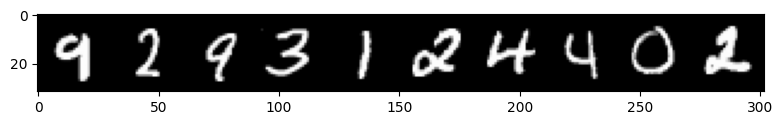

In [249]:
#Visualize the data:

#Grab first batch of images:
for images, labels in train_dataloader:
    break
    
#Print and show the first 10 samples:

print(f"Labels: {labels[0:10]}")
im = make_grid(images[:10], nrow=10)
plt.figure(figsize=(10,1))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC

Now that we have set up our data, let us construct the Vanilla Autoencoder with linear layers. We know that the input to the first layer should be the flattened MNIST data dimension. Following this, the layers of the AE encoder get iteratively smaller until the bottleneck (last layer of our encoder), which dictates the latent dimension size. The decoder is a mirror reflection of the encoder. Refer to [Hinton et. al.](https://www.science.org/doi/10.1126/science.1127647) for an idea on standard architecture if you are stuck. You may also utilize the helper code MLP, but it is not required.

### AE Model & Train

In [250]:
#Some Optional Helper Code:

'''def mlp(in_dim, out_dim, hidden_dim, n_layers):
    layers = []
    layers.append(nn.Linear(in_dim, hidden_dim))
    layers.append(nn.ReLU())
    for _ in range(n_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_dim, out_dim))
    return nn.Sequential(*layers)'''

def mlp(in_dim, out_dim, encode=True):
    #A helper function that compactly creates an MLP for
    #
    layers = []
    if encode:
        next_dim = 2**math.floor(math.log2(in_dim))
    else:
        next_dim = 2**math.ceil(math.log2(in_dim))
        
    firstLayer = nn.Linear(in_dim, next_dim)
    layers.extend([firstLayer, nn.ReLU()])
    in_dim = next_dim
        
    while in_dim != out_dim:
        if encode:
            next_dim = in_dim//2
            if next_dim < out_dim:
                next_dim = out_dim
        else:
            next_dim = in_dim*2
            if next_dim > out_dim:
                next_dim = out_dim
        layers.extend([nn.Linear(in_dim, next_dim), nn.ReLU()])
        in_dim = next_dim
        
    return nn.Sequential(*layers)

def add_noise(tensor, mean=0., std=1., noise_weight=0.5):
    noise = torch.randn(tensor.size()) * std + mean
    return torch.clip(tensor + noise_weight * noise, 0., 1.)

In [251]:
class AE(nn.Module):
    def __init__(self, in_dim=784, latent_dim=512):
        super().__init__()
        self.encoder = mlp(in_dim, latent_dim, encode=True)
        
        '''
        There are many alternate solutions as long as the layer dimensions proceed in a non-decreasing order to a smaller bottleneck
        nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )'''
        self.decoder = mlp(latent_dim, 784, encode=False)
        
        
        '''nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )'''

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x_in, x_star):
        z = self.encode(x_in)
        x_hat = self.decode(z)

        loss = self.loss(x_star, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat)
        return loss
    @staticmethod
    def loss(x, x_hat):
        #Mean-Squared Error Reconstruction Loss
        return ((x - x_hat) ** 2).mean()



The training loop is set up for you. Feel free to tinker with the hyperparameters + model architecture at this point if you would like.

In [252]:
#Training Loop for Autoencoder

# model and optimizer
ae = AE(784, 512)
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# train
ae_train_losses = []
ae_test_losses = []
step = 0
report_every = 500
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    #train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=0.5)
        else:
            x_in = x_no_noise
        loss = ae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        ae_train_losses.append(loss.detach().numpy()) #loss every iteration
        step += 1
        if step % report_every == 0:
            print(f"Training loss: {loss}")
    #ae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    #test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        loss = ae.test_step(X_test)
        ae_test_losses.append(loss.detach().numpy()) #loss every iteration
    #ae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 54%|███████████████████████████████████████████████████████▎                                              | 509/938 [00:08<00:06, 61.79it/s]

Training loss: 0.012908839620649815


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 59.98it/s]


Epoch 2


  7%|███████▋                                                                                               | 70/938 [00:01<00:13, 62.18it/s]

Training loss: 0.011736714281141758


 61%|█████████████████████████████████████████████████████████████▉                                        | 570/938 [00:09<00:05, 64.20it/s]

Training loss: 0.010702700354158878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 60.75it/s]


Epoch 3


 14%|██████████████▏                                                                                       | 130/938 [00:05<00:22, 36.01it/s]

Training loss: 0.011061832308769226


 67%|████████████████████████████████████████████████████████████████████▊                                 | 633/938 [00:14<00:05, 59.07it/s]

Training loss: 0.008927593939006329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 48.00it/s]


Epoch 4


 21%|█████████████████████                                                                                 | 194/938 [00:03<00:13, 55.65it/s]

Training loss: 0.01038461085408926


 74%|███████████████████████████████████████████████████████████████████████████▎                          | 693/938 [00:11<00:03, 62.98it/s]

Training loss: 0.009807066060602665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 60.30it/s]


Epoch 5


 28%|████████████████████████████                                                                          | 258/938 [00:04<00:10, 62.79it/s]

Training loss: 0.00953606702387333


 80%|██████████████████████████████████████████████████████████████████████████████████                    | 755/938 [00:12<00:03, 49.51it/s]

Training loss: 0.009640661999583244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 56.56it/s]


Epoch 6


 34%|██████████████████████████████████▉                                                                   | 321/938 [00:05<00:09, 63.32it/s]

Training loss: 0.009317493066191673


 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 820/938 [00:14<00:02, 58.68it/s]

Training loss: 0.011130841448903084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.36it/s]


Epoch 7


 41%|█████████████████████████████████████████▊                                                            | 384/938 [00:06<00:08, 63.19it/s]

Training loss: 0.008133805356919765


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 881/938 [00:14<00:00, 61.91it/s]

Training loss: 0.010496889241039753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 62.03it/s]


Epoch 8


 47%|███████████████████████████████████████████████▊                                                      | 440/938 [00:07<00:07, 62.37it/s]

Training loss: 0.008662432432174683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 62.67it/s]


Training loss: 0.008169266395270824
Epoch 9


 54%|███████████████████████████████████████████████████████▏                                              | 507/938 [00:08<00:06, 62.09it/s]

Training loss: 0.009246171452105045


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:22<00:00, 42.32it/s]


Epoch 10


  7%|███████▍                                                                                               | 68/938 [00:01<00:14, 60.91it/s]

Training loss: 0.009398567490279675


 60%|█████████████████████████████████████████████████████████████▎                                        | 564/938 [00:10<00:05, 63.12it/s]

Training loss: 0.00833277776837349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 55.37it/s]


### Thinking Critically About the Architecture:

Alright, we have now trained our linear-layer (Vanilla) Autoencoder! Before directly moving on to Variational Autoencoders, let us see if we can't critically analyze the benefits and shortcomings of the Autoencoder.

Let us think a little more closely about the latent representation of the Autoencoder. We note that besides optimizing the reconstruction loss, there are no further restrictions on the latent code. Because of this, we can't really ensure that the latent space representation being learned is anything semantically meaningful or even practically useful (besides being good at reconstruction of course!).

Due to this lack of an informative latent space, (Vanilla) Autoencoders have more trouble with **denoising** and **content generation** tasks. One way to fix this is to regularize the latent code using some prior. 

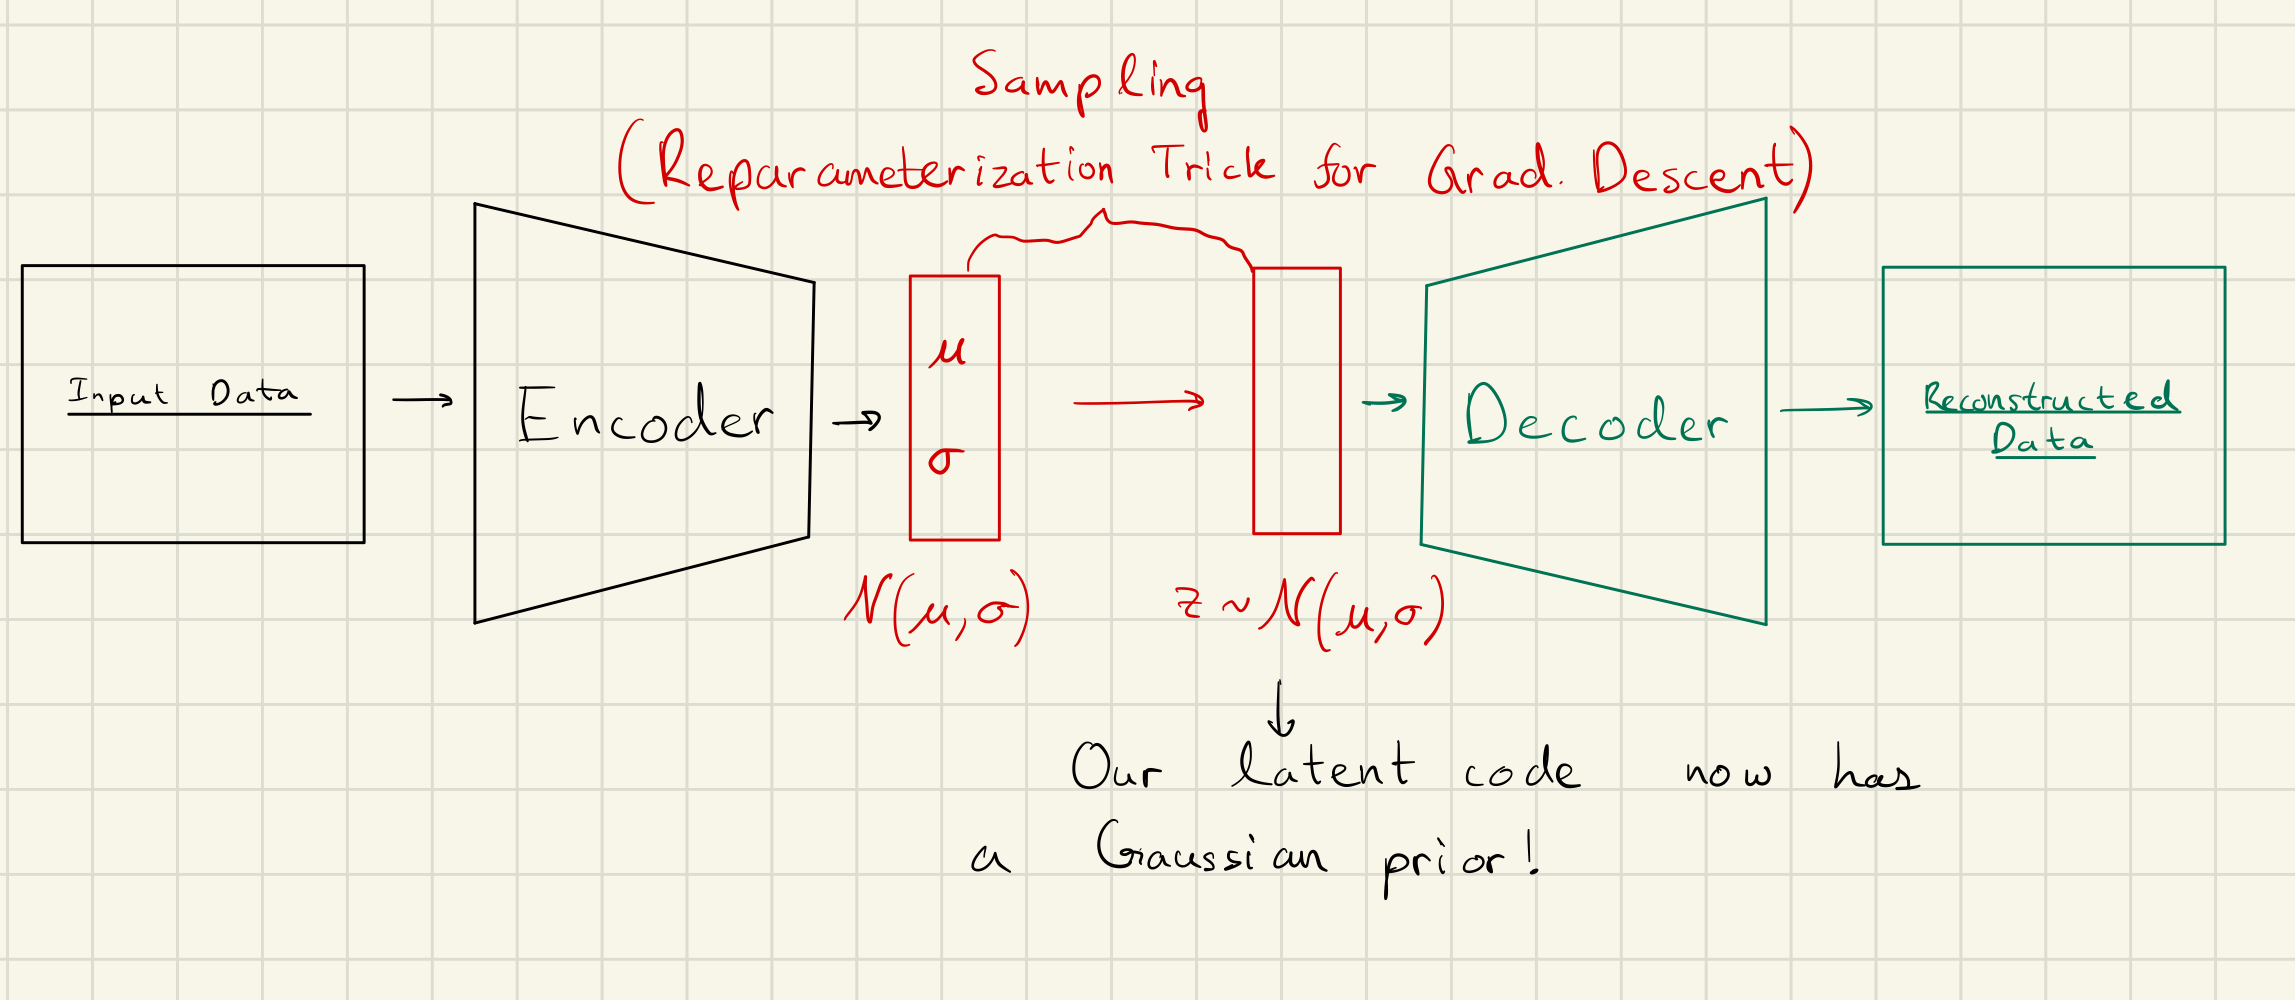

Finally, to enforce this regularization, our loss objective thus becomes:

$$\|X - g(f(X))\|^2 + \lambda\mathrm{KL}[\mathcal{N}(\mu,\,\sigma^{2}), \mathcal{N}(0,\,I)]$$

where $\mathrm{KL}(\cdot) represents the KL-divergence. Without loss of generality, we measure the KL divergence between our latent distribution and the standard normal distribution.

### Concept Check 2.1

## VAE With Linear Layers on MNIST:

### VAE Model & Train

In [265]:
# VAE hyperparams
epochs = 5
lr = 1e-3
batch_size = 64
noise = False
input_dim = 784
latent_dim=512
regularization_weight = .0001

In [240]:
class VAE(nn.Module):
    def __init__(self, input_dim=1*28*28, latent_dim=512):
        super().__init__()
        self.z_mean = mlp(input_dim, latent_dim, encode=True)
        self.z_log_std = mlp(input_dim, latent_dim, encode=True)
        self.decoder = mlp(latent_dim, input_dim, encode=False)
    
    def _encode(self, x):
        z_mean = self.z_mean(x)
        z_log_std = self.z_log_std(x)

        # reparameterization trick
        z_std = torch.exp(z_log_std)
        eps = torch.randn_like(z_std)
        z = z_mean + eps * z_std

        # log prob
        # 'd' not sampled on purpose
        # to show reparameterization trick
        d = Independent(Normal(z_mean, z_std), 1)
        log_prob = d.log_prob(z)

        return z_mean + eps * z_std, log_prob
    
    def encode(self, x):
        z, _ = self._encode(x)
        return z

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x_in, x_star):
        z, log_prob = self._encode(x_in)
        x_hat = self.decode(z)

        loss = self.loss(x_star, x_hat, z, log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    def test_step(self, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)
        
        loss = self.loss(x, x_hat, z, log_prob)
        return loss

    @staticmethod
    def loss(x, x_hat, z, log_prob, kl_weight=regularization_weight):
        reconst_loss = ((x - x_hat) ** 2).mean()

        z_dim = z.shape[-1]
        standard_normal = MultivariateNormal(torch.zeros(z_dim), 
                                             torch.eye(z_dim))
        kld_loss = (log_prob - standard_normal.log_prob(z)).mean()
        
        return reconst_loss + kl_weight * kld_loss

Again, feel free to tinker with the architecture or the hyperparameters if you would like.

In [241]:
#Training Loop for Autoencoder

# model and optimizer
vae = VAE(input_dim, latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

# train
vae_train_losses = []
vae_test_losses = []
step = 0
report_every = 100
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    #train loss:
    for x, y in tqdm(train_dataloader):
        x_no_noise = x.reshape(x.shape[0], -1)  # flatten
        if noise:
            x_in = add_noise(x_no_noise, noise_weight=0.5)
        else:
            x_in = x_no_noise
        loss = vae.train_step(optimizer, x_in=x_in, x_star=x_no_noise)
        vae_train_losses.append(loss.detach().numpy()) #loss every iteration
        step += 1
        if step % report_every == 0:
            print(f"Training loss: {loss}")
    #vae_train_losses.append(loss.detach().numpy()) #loss after every epoch
    #test loss
    for b, (X_test, y_test) in enumerate(test_dataloader):
        X_test = X_test.reshape(X_test.shape[0], -1)  # flatten
        loss = vae.test_step(X_test)
        vae_test_losses.append(loss.detach().numpy()) #loss every iteration
    #vae_test_losses.append(loss.detach().numpy()) #loss after every epoch

Epoch 1


 11%|███████████▎                                                                                          | 104/938 [00:05<00:27, 30.08it/s]

Training loss: 0.047638583928346634


 22%|██████████████████████▍                                                                               | 206/938 [00:08<00:20, 35.43it/s]

Training loss: 0.042058419436216354


 33%|█████████████████████████████████▎                                                                    | 306/938 [00:11<00:21, 30.07it/s]

Training loss: 0.03849257156252861


 43%|████████████████████████████████████████████▎                                                         | 407/938 [00:15<00:15, 34.35it/s]

Training loss: 0.03504735976457596


 54%|███████████████████████████████████████████████████████▏                                              | 507/938 [00:18<00:11, 35.97it/s]

Training loss: 0.034482911229133606


 65%|██████████████████████████████████████████████████████████████████                                    | 607/938 [00:21<00:09, 36.50it/s]

Training loss: 0.034646619111299515


 75%|████████████████████████████████████████████████████████████████████████████▋                         | 705/938 [00:24<00:09, 23.60it/s]

Training loss: 0.032330408692359924


 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 805/938 [00:27<00:03, 34.78it/s]

Training loss: 0.03504304587841034


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 905/938 [00:31<00:00, 35.18it/s]

Training loss: 0.0331733375787735


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 28.81it/s]


Epoch 2


  7%|███████▎                                                                                               | 67/938 [00:03<00:50, 17.09it/s]

Training loss: 0.032850224524736404


 18%|██████████████████▎                                                                                   | 168/938 [00:07<00:22, 33.68it/s]

Training loss: 0.03197971731424332


 29%|█████████████████████████████▏                                                                        | 268/938 [00:10<00:19, 34.62it/s]

Training loss: 0.03289804980158806


 39%|████████████████████████████████████████                                                              | 368/938 [00:12<00:16, 34.38it/s]

Training loss: 0.03061111830174923


 50%|██████████████████████████████████████████████████▉                                                   | 468/938 [00:16<00:14, 31.51it/s]

Training loss: 0.030548634007573128


 61%|█████████████████████████████████████████████████████████████▊                                        | 568/938 [00:19<00:11, 30.94it/s]

Training loss: 0.030518317595124245


 71%|████████████████████████████████████████████████████████████████████████▋                             | 668/938 [00:22<00:07, 34.41it/s]

Training loss: 0.031308695673942566


 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 768/938 [00:25<00:05, 32.97it/s]

Training loss: 0.030274884775280952


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 868/938 [00:28<00:01, 36.18it/s]

Training loss: 0.03042418509721756


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 31.19it/s]


Epoch 3


  3%|███                                                                                                    | 28/938 [00:00<00:25, 35.48it/s]

Training loss: 0.03130380064249039


 14%|█████████████▉                                                                                        | 128/938 [00:03<00:22, 36.07it/s]

Training loss: 0.0318269319832325


 24%|████████████████████████▊                                                                             | 228/938 [00:06<00:19, 35.91it/s]

Training loss: 0.03196775168180466


 35%|███████████████████████████████████▋                                                                  | 328/938 [00:09<00:16, 36.29it/s]

Training loss: 0.030800295993685722


 46%|██████████████████████████████████████████████▌                                                       | 428/938 [00:12<00:14, 36.21it/s]

Training loss: 0.030852507799863815


 56%|█████████████████████████████████████████████████████████▍                                            | 528/938 [00:14<00:12, 32.88it/s]

Training loss: 0.02965713106095791


 67%|████████████████████████████████████████████████████████████████████▎                                 | 628/938 [00:17<00:08, 36.04it/s]

Training loss: 0.03148144856095314


 78%|███████████████████████████████████████████████████████████████████████████████▏                      | 728/938 [00:20<00:06, 33.02it/s]

Training loss: 0.03088531643152237


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 831/938 [00:23<00:03, 32.48it/s]

Training loss: 0.030440226197242737


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 931/938 [00:26<00:00, 36.12it/s]

Training loss: 0.030661040917038918


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 35.23it/s]


Epoch 4


 10%|█████████▉                                                                                             | 90/938 [00:02<00:23, 36.02it/s]

Training loss: 0.0305746179074049


 20%|████████████████████▋                                                                                 | 190/938 [00:05<00:20, 36.06it/s]

Training loss: 0.030039101839065552


 31%|███████████████████████████████▌                                                                      | 290/938 [00:08<00:18, 34.26it/s]

Training loss: 0.03147529810667038


 42%|██████████████████████████████████████████▍                                                           | 390/938 [00:11<00:15, 36.11it/s]

Training loss: 0.028896324336528778


 52%|█████████████████████████████████████████████████████▎                                                | 490/938 [00:13<00:12, 36.34it/s]

Training loss: 0.030995987355709076


 63%|████████████████████████████████████████████████████████████████▏                                     | 590/938 [00:16<00:09, 35.80it/s]

Training loss: 0.028533833101391792


 74%|███████████████████████████████████████████████████████████████████████████                           | 690/938 [00:19<00:07, 35.11it/s]

Training loss: 0.02987040765583515


 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 790/938 [00:22<00:04, 35.16it/s]

Training loss: 0.02883465215563774


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 890/938 [00:25<00:01, 35.88it/s]

Training loss: 0.028856905177235603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 35.43it/s]


Epoch 5


  6%|█████▋                                                                                                 | 52/938 [00:01<00:24, 36.12it/s]

Training loss: 0.03245307132601738


 16%|████████████████▌                                                                                     | 152/938 [00:04<00:22, 35.13it/s]

Training loss: 0.02890295907855034


 27%|███████████████████████████▍                                                                          | 252/938 [00:07<00:19, 36.04it/s]

Training loss: 0.027619782835245132


 38%|██████████████████████████████████████▎                                                               | 352/938 [00:09<00:16, 36.31it/s]

Training loss: 0.027575474232435226


 48%|█████████████████████████████████████████████████▏                                                    | 452/938 [00:12<00:16, 29.96it/s]

Training loss: 0.030744755640625954


 59%|████████████████████████████████████████████████████████████                                          | 552/938 [00:15<00:10, 35.99it/s]

Training loss: 0.028779875487089157


 70%|██████████████████████████████████████████████████████████████████████▉                               | 652/938 [00:18<00:07, 36.22it/s]

Training loss: 0.029049774631857872


 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 752/938 [00:21<00:05, 36.16it/s]

Training loss: 0.03004084900021553


 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 852/938 [00:23<00:02, 36.37it/s]

Training loss: 0.029952071607112885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 35.60it/s]


Epoch 6


  2%|█▊                                                                                                     | 16/938 [00:00<00:25, 36.00it/s]

Training loss: 0.02804958075284958


 12%|████████████▏                                                                                         | 112/938 [00:03<00:28, 29.48it/s]

Training loss: 0.028041353449225426


 23%|███████████████████████▍                                                                              | 216/938 [00:06<00:19, 36.24it/s]

Training loss: 0.02911560982465744


 34%|██████████████████████████████████▎                                                                   | 316/938 [00:09<00:17, 36.19it/s]

Training loss: 0.029781118035316467


 44%|█████████████████████████████████████████████▏                                                        | 416/938 [00:11<00:14, 36.07it/s]

Training loss: 0.03163694590330124


 55%|████████████████████████████████████████████████████████                                              | 516/938 [00:14<00:11, 36.35it/s]

Training loss: 0.028142863884568214


 66%|██████████████████████████████████████████████████████████████████▉                                   | 616/938 [00:17<00:09, 35.32it/s]

Training loss: 0.028975876048207283


 76%|█████████████████████████████████████████████████████████████████████████████▊                        | 716/938 [00:20<00:06, 36.03it/s]

Training loss: 0.03026433289051056


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 816/938 [00:23<00:03, 33.69it/s]

Training loss: 0.028848901391029358


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 913/938 [00:26<00:00, 36.07it/s]

Training loss: 0.029078099876642227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:27<00:00, 34.65it/s]


Epoch 7


  8%|████████▎                                                                                              | 76/938 [00:02<00:23, 36.20it/s]

Training loss: 0.027177374809980392


 19%|███████████████████▏                                                                                  | 176/938 [00:04<00:21, 36.08it/s]

Training loss: 0.028558209538459778


 29%|██████████████████████████████                                                                        | 276/938 [00:07<00:18, 36.40it/s]

Training loss: 0.02903836779296398


 40%|████████████████████████████████████████▉                                                             | 376/938 [00:10<00:15, 36.44it/s]

Training loss: 0.026160702109336853


 51%|███████████████████████████████████████████████████▊                                                  | 476/938 [00:13<00:12, 36.43it/s]

Training loss: 0.027182217687368393


 61%|██████████████████████████████████████████████████████████████▋                                       | 576/938 [00:15<00:09, 36.37it/s]

Training loss: 0.02885502576828003


 72%|█████████████████████████████████████████████████████████████████████████▌                            | 676/938 [00:18<00:07, 35.42it/s]

Training loss: 0.03344673290848732


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 779/938 [00:22<00:06, 25.00it/s]

Training loss: 0.029775120317935944


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 879/938 [00:25<00:01, 35.95it/s]

Training loss: 0.026795674115419388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 34.77it/s]


Epoch 8


  4%|████▍                                                                                                  | 40/938 [00:01<00:24, 36.34it/s]

Training loss: 0.028661061078310013


 15%|███████████████                                                                                       | 138/938 [00:04<00:23, 34.56it/s]

Training loss: 0.026985295116901398


 25%|█████████████████████████▉                                                                            | 238/938 [00:07<00:19, 36.24it/s]

Training loss: 0.028305336833000183


 36%|████████████████████████████████████▊                                                                 | 338/938 [00:09<00:16, 36.07it/s]

Training loss: 0.027201615273952484


 47%|███████████████████████████████████████████████▋                                                      | 438/938 [00:12<00:13, 36.36it/s]

Training loss: 0.029091693460941315


 57%|██████████████████████████████████████████████████████████▌                                           | 538/938 [00:15<00:11, 36.13it/s]

Training loss: 0.02978939563035965


 68%|█████████████████████████████████████████████████████████████████████▍                                | 638/938 [00:18<00:08, 36.13it/s]

Training loss: 0.02742093987762928


 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 738/938 [00:20<00:05, 35.69it/s]

Training loss: 0.027862530201673508


 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 838/938 [00:23<00:02, 35.81it/s]

Training loss: 0.028372913599014282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 35.24it/s]

Training loss: 0.0300371665507555


Epoch 9


 11%|██████████▊                                                                                            | 99/938 [00:03<00:31, 26.87it/s]

Training loss: 0.02829187735915184


 21%|█████████████████████▋                                                                                | 200/938 [00:06<00:21, 34.16it/s]

Training loss: 0.02820751816034317


 32%|████████████████████████████████▌                                                                     | 300/938 [00:09<00:17, 35.78it/s]

Training loss: 0.027797434478998184


 43%|███████████████████████████████████████████▍                                                          | 400/938 [00:12<00:15, 35.64it/s]

Training loss: 0.030876103788614273


 53%|██████████████████████████████████████████████████████▎                                               | 500/938 [00:14<00:12, 35.93it/s]

Training loss: 0.027564166113734245


 64%|█████████████████████████████████████████████████████████████████▏                                    | 600/938 [00:17<00:09, 36.28it/s]

Training loss: 0.030782895162701607


 75%|████████████████████████████████████████████████████████████████████████████                          | 700/938 [00:20<00:06, 35.95it/s]

Training loss: 0.027154363691806793


 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 800/938 [00:23<00:03, 36.19it/s]

Training loss: 0.028164474293589592


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 900/938 [00:25<00:01, 36.37it/s]

Training loss: 0.02886784076690674


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:27<00:00, 34.74it/s]


Epoch 10


  7%|███████                                                                                                | 64/938 [00:01<00:24, 36.30it/s]

Training loss: 0.02933468483388424


 17%|█████████████████▊                                                                                    | 164/938 [00:04<00:21, 36.47it/s]

Training loss: 0.027723105624318123


 28%|████████████████████████████▋                                                                         | 264/938 [00:07<00:18, 36.31it/s]

Training loss: 0.02825772389769554


 39%|███████████████████████████████████████▌                                                              | 364/938 [00:10<00:15, 36.27it/s]

Training loss: 0.02710905112326145


 49%|██████████████████████████████████████████████████▍                                                   | 464/938 [00:12<00:13, 36.33it/s]

Training loss: 0.029406199231743813


 60%|█████████████████████████████████████████████████████████████▎                                        | 564/938 [00:15<00:10, 36.31it/s]

Training loss: 0.028325755149126053


 71%|████████████████████████████████████████████████████████████████████████▏                             | 664/938 [00:18<00:07, 36.47it/s]

Training loss: 0.03004629909992218


 81%|███████████████████████████████████████████████████████████████████████████████████                   | 764/938 [00:21<00:04, 36.26it/s]

Training loss: 0.02754353918135166


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 860/938 [00:23<00:02, 35.91it/s]

Training loss: 0.030081693083047867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 35.91it/s]


### Concept Check 2.2-2.3 (while you wait for the model to train)

## Ablations and Visualizations:

If you would like to understand more how these visualizations and ablations were implemented, feel free to peruse the code. However, for the most part take a close, critical look at the results. Some of these are really interesting and informative!

### 1. Loss Visualization:

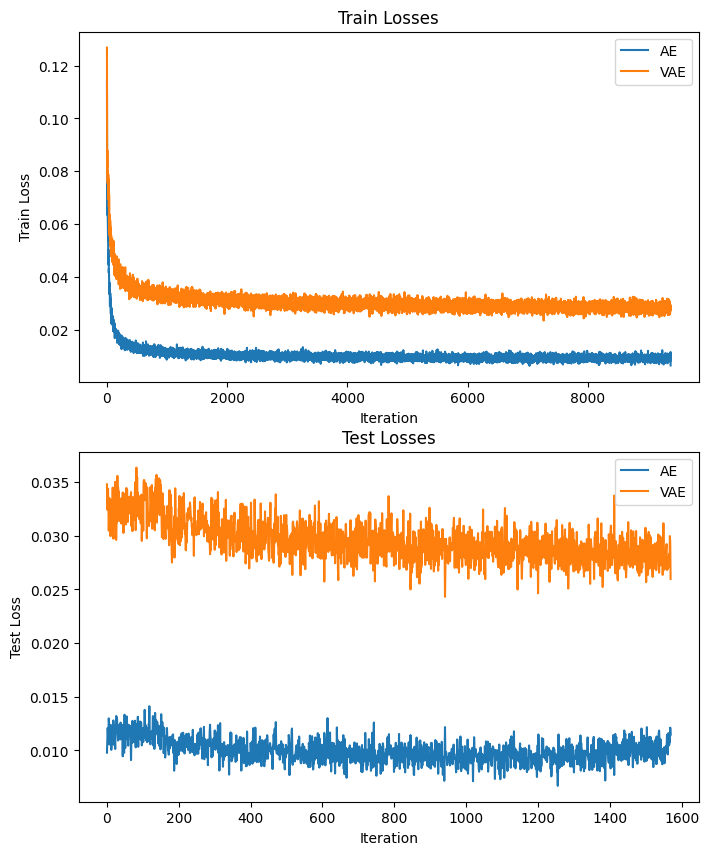

In [255]:
 with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()
    
    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

### 2. Visualize Reconstructed Samples

Labels: tensor([4, 0, 2, 9, 8, 8, 0, 9, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


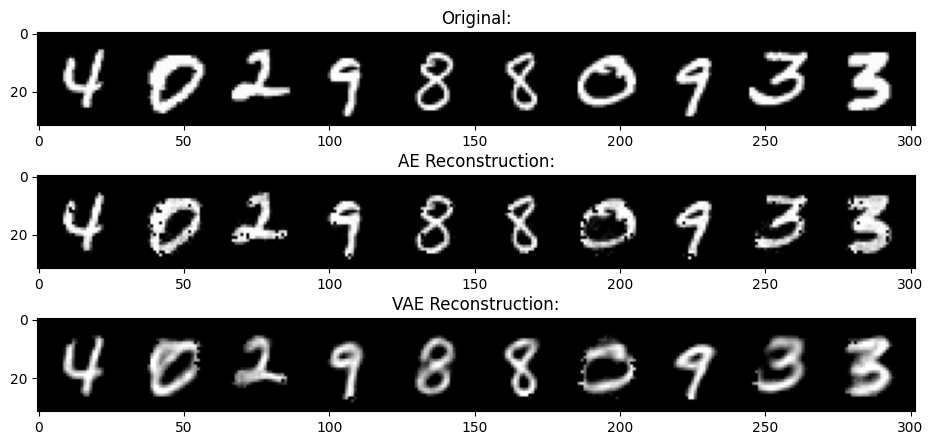

In [256]:
#Visualize the samples in bulk:

with torch.no_grad():
    #Grab first batch of images:
    for images, labels in test_dataloader:
        recon_ae = ae.decode(ae.encode(images.reshape((batch_size, -1)))).reshape((batch_size, 1, 28, 28))
        recon_vae = vae.decode(vae.encode(images.reshape((batch_size, -1)))).reshape((batch_size, 1, 28, 28))
        break


    #Print and show the first 10 samples:

    print(f"Labels: {labels[0:10]}")
    im = make_grid(images[:10], nrow=10)
    ae_im = make_grid(recon_ae[:10], nrow=10)
    vae_im = make_grid(recon_vae[:10], nrow=10)
    fig, ax = plt.subplots(3, figsize=(45,4.5))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")

    ax[1].imshow(np.transpose(ae_im.numpy(), (1, 2, 0)))
    ax[1].set_title("AE Reconstruction:")
    
    ax[2].imshow(np.transpose(vae_im.numpy(), (1, 2, 0)))
    ax[2].set_title("VAE Reconstruction:")

### Concept Check 2.4.1

### 3. Visualizing the Latent Space:

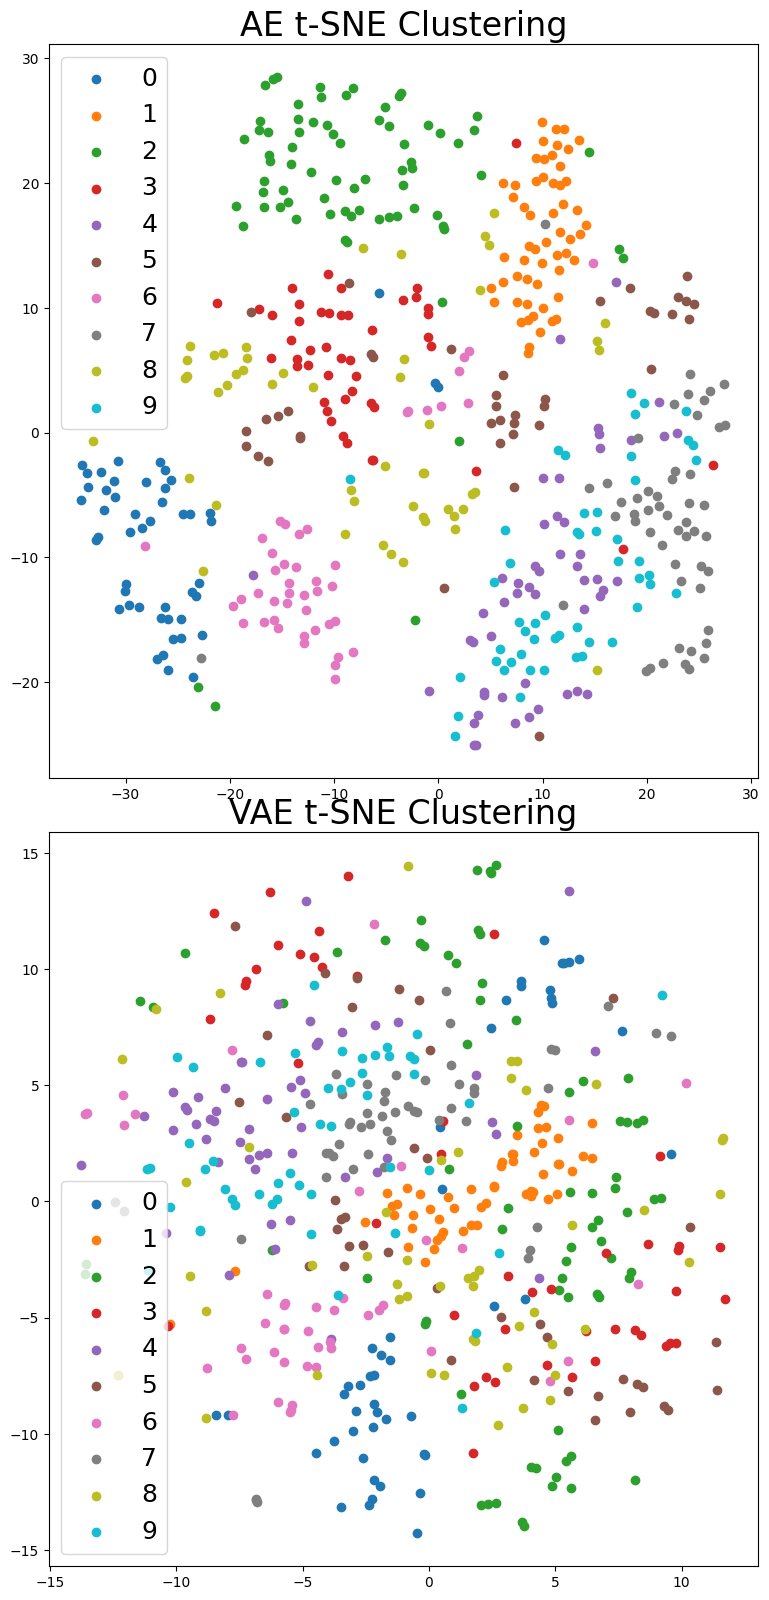

In [257]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    for (data, labels) in viz_dataloader:
        break

    tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
    recon_ae = ae.encode(data.reshape((num_samples, -1)))
    recon_vae = vae.encode(data.reshape((num_samples, -1)))
    embedded_ae = tsne.fit_transform(recon_ae)
    embedded_vae = tsne.fit_transform(recon_vae)
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig, ax = plt.subplots(2, figsize=(8,16))
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax[0].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[0].legend(labels=range(10), fontsize=18)
    ax[0].set_title("AE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[0].show()
    
    for label, group in label_groups_vae:
        ax[1].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[1].legend(labels=range(10), fontsize=18)
    ax[1].set_title("VAE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[1].show()

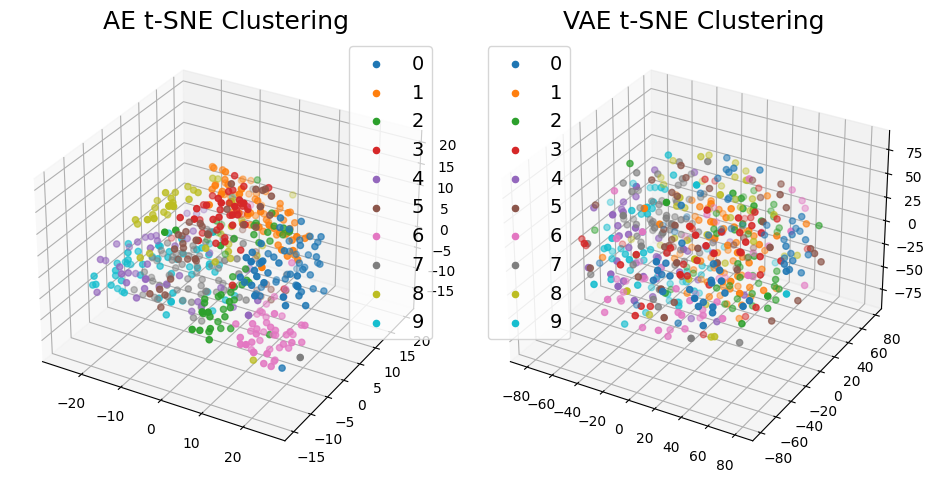

In [258]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    for (data, labels) in viz_dataloader:
        break

    tsne = TSNE(n_components=3, perplexity=30.0, random_state=0)
    recon_ae = ae.encode(data.reshape((num_samples, -1)))
    recon_vae = vae.encode(data.reshape((num_samples, -1)))
    embedded_ae = tsne.fit_transform(recon_ae)
    embedded_vae = tsne.fit_transform(recon_vae)
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "c3", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2","c3", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax0.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax0.legend(labels=range(10), fontsize=14)
    ax0.set_title("AE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[0].show()
    
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    for label, group in label_groups_vae:
        ax1.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax1.legend(labels=range(10), fontsize=14)
    ax1.set_title("VAE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[1].show()

### Concept Check 2.4.2

### 4. AE/VAE Denoising:

Now, let us see the denoising capabilities of these architectures. Go back to the function add noise in order to add some Gaussian noise to the training data, $X$. You can adjust how reasonable the noise is by adding a coefficient in front of the noise term, which can act as a hyperparameter. Then, apply this noise to the sample when training.

*(Hint: torch.randn may be helpful here. Also, consider what range of values may be outputted when you add noise. Is this consistent with the data type of MNIST? How might you account for this.)*

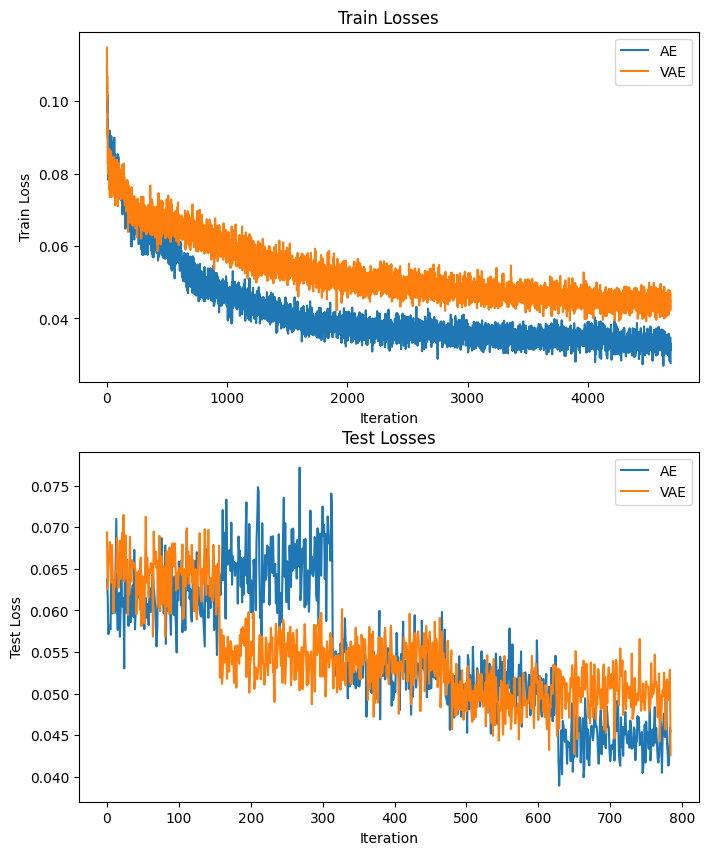

In [189]:
with torch.no_grad():
    fig, ax = plt.subplots(2, figsize=(8,10))
    ax[0].plot(ae_train_losses, label="AE")
    ax[0].plot(vae_train_losses, label="VAE")
    ax[0].set_title("Train Losses")
    ax[0].set_ylabel("Train Loss")
    ax[0].set_xlabel("Iteration")
    ax[0].legend()

    ax[1].plot(ae_test_losses, label="AE")
    ax[1].plot(vae_test_losses, label="VAE")
    ax[1].set_title("Test Losses")
    ax[1].set_ylabel("Test Loss")
    ax[1].set_xlabel("Iteration")
    ax[1].legend()

#Note: if you want per epoch (or avg. epoch) losses, you will have to change the above code somewhat

Labels: tensor([1, 4, 9, 5, 7, 3, 9, 4, 2, 5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


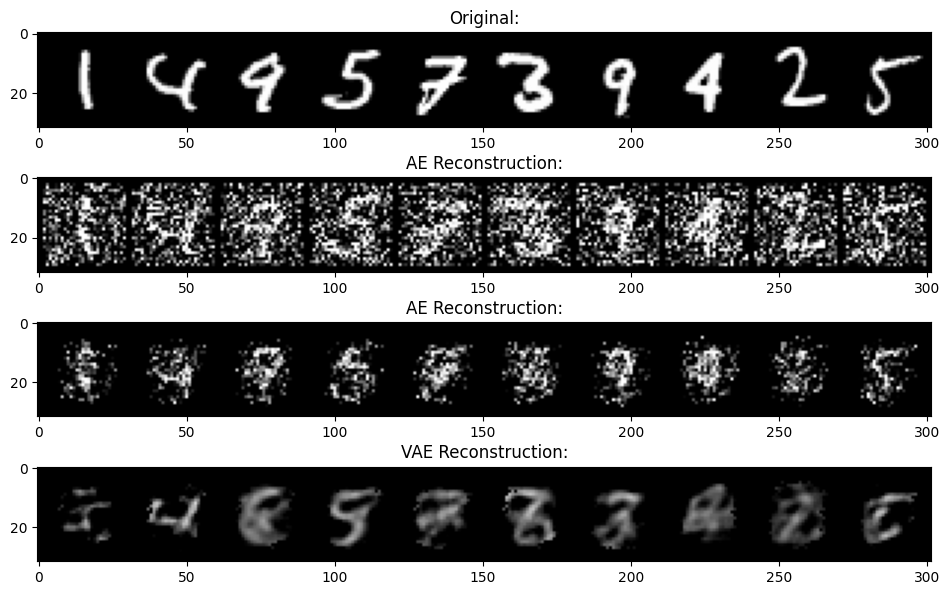

In [267]:
#Visualize the samples in bulk:

with torch.no_grad():
    #Grab first batch of images:
    for images, labels in test_dataloader:
        
        break


    #Add Noise to images:
    noise_images = add_noise(images, noise_weight=0.65)
    
    recon_ae = ae.decode(ae.encode(noise_images.reshape((batch_size, -1)))).reshape((batch_size, 1, 28, 28))
    recon_vae = vae.decode(vae.encode(noise_images.reshape((batch_size, -1)))).reshape((batch_size, 1, 28, 28))
    
    #Print and show the first 10 samples:
    print(f"Labels: {labels[0:10]}")
    im = make_grid(images[:10], nrow=10)
    noise_im = make_grid(noise_images[:10], nrow=10)
    ae_im = make_grid(recon_ae[:10], nrow=10)
    vae_im = make_grid(recon_vae[:10], nrow=10)
    fig, ax = plt.subplots(4, figsize=(60,6))
    fig.tight_layout(pad=1.5)
    ax[0].imshow(np.transpose(im.numpy(), (1, 2, 0))) #Remember that default MNIST data is CWH, but matplotlib uses WHC
    ax[0].set_title("Original:")
    
    ax[1].imshow(np.transpose(noise_im.numpy(), (1, 2, 0)))
    ax[1].set_title("AE Reconstruction:")

    ax[2].imshow(np.transpose(ae_im.numpy(), (1, 2, 0)))
    ax[2].set_title("AE Reconstruction:")
    
    ax[3].imshow(np.transpose(vae_im.numpy(), (1, 2, 0)))
    ax[3].set_title("VAE Reconstruction:")

### Concept Check 2.3.3

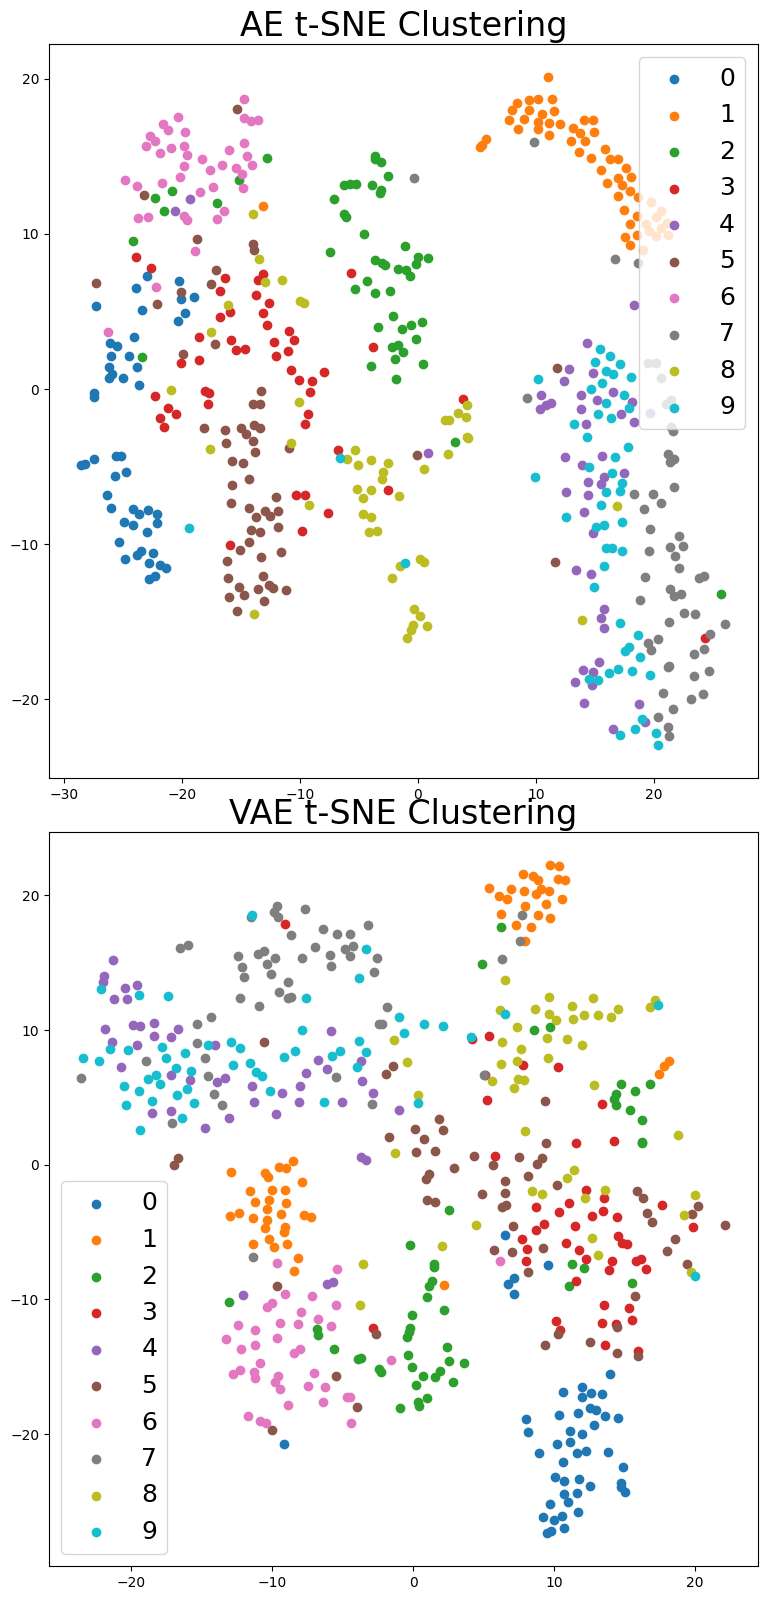

In [190]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    for (data, labels) in viz_dataloader:
        break

    tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
    recon_ae = ae.encode(data.reshape((num_samples, -1)))
    recon_vae = vae.encode(data.reshape((num_samples, -1)))
    embedded_ae = tsne.fit_transform(recon_ae)
    embedded_vae = tsne.fit_transform(recon_vae)
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig, ax = plt.subplots(2, figsize=(8,16))
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax[0].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[0].legend(labels=range(10), fontsize=18)
    ax[0].set_title("AE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[0].show()
    
    for label, group in label_groups_vae:
        ax[1].scatter(group["c1"], group["c2"], marker="o", label=label)

    ax[1].legend(labels=range(10), fontsize=18)
    ax[1].set_title("VAE t-SNE Clustering", fontdict={"fontsize": 24})
    #ax[1].show()

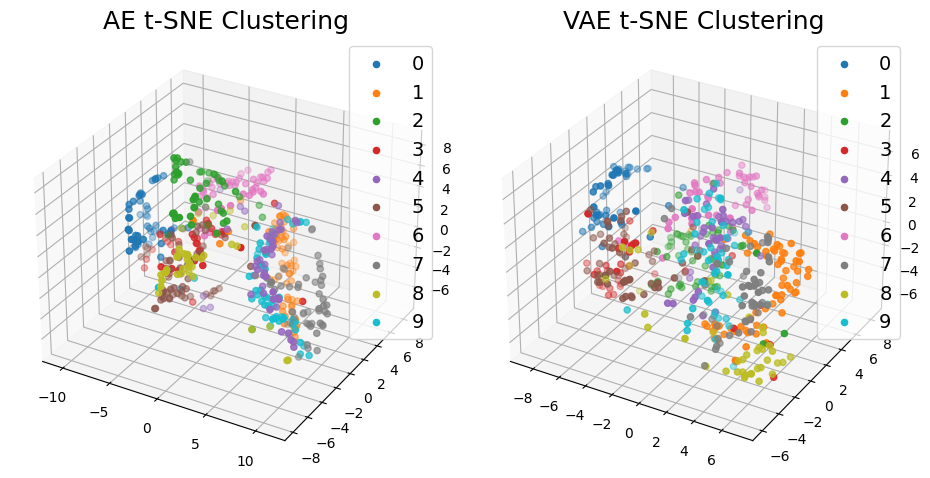

In [191]:
# analysis
with torch.no_grad():
    num_samples = 512

    viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)
    for (data, labels) in viz_dataloader:
        break

    tsne = TSNE(n_components=3, perplexity=30.0, random_state=0)
    recon_ae = ae.encode(data.reshape((num_samples, -1)))
    recon_vae = vae.encode(data.reshape((num_samples, -1)))
    embedded_ae = tsne.fit_transform(recon_ae)
    embedded_vae = tsne.fit_transform(recon_vae)
    two_components_ae = np.hstack((embedded_ae, labels.numpy().reshape(-1, 1)))
    two_components_ae = pd.DataFrame(data=two_components_ae)
    two_components_ae.columns = ["c1", "c2", "c3", "label"]

    label_groups_ae = two_components_ae.groupby("label")
    
    two_components_vae = np.hstack((embedded_vae, labels.numpy().reshape(-1, 1)))
    two_components_vae = pd.DataFrame(data=two_components_vae)
    two_components_vae.columns = ["c1", "c2","c3", "label"]

    label_groups_vae = two_components_vae.groupby("label")
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    fig.tight_layout(pad=1.75)
    #plt.figure(figsize=(10, 10))
    for label, group in label_groups_ae:
        ax0.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax0.legend(labels=range(10), fontsize=14)
    ax0.set_title("AE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[0].show()
    
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    for label, group in label_groups_vae:
        ax1.scatter(group["c1"], group["c2"], group["c3"], marker="o", label=label)

    ax1.legend(labels=range(10), fontsize=14)
    ax1.set_title("VAE t-SNE Clustering", fontdict={"fontsize": 18})
    #ax[1].show()

### 5. Generating New Samples

#### 5a. AE:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


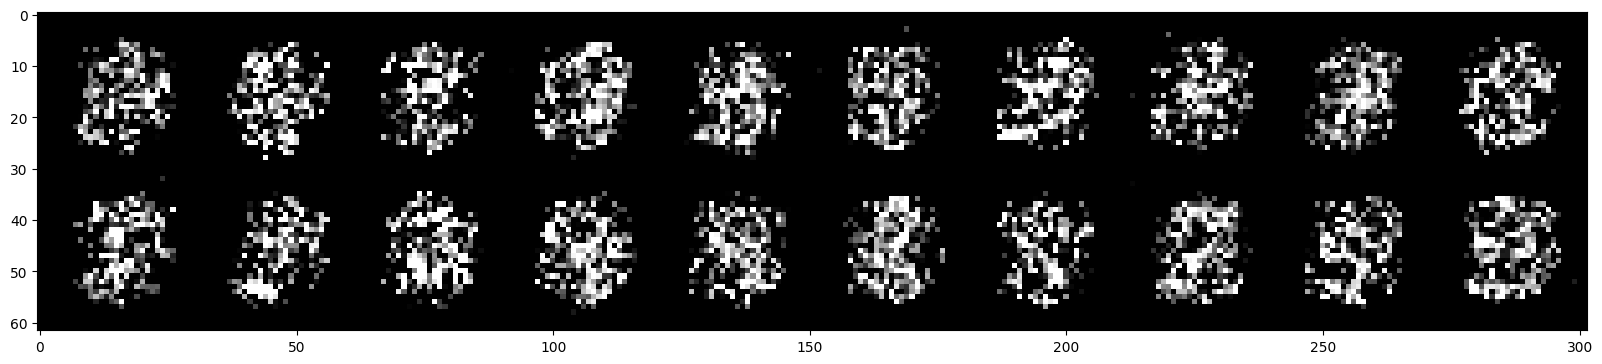

In [259]:
ae.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    for (images, labels) in test_dataloader:
        break
    images = images#.to(device)
    latent = vae.encode(images.reshape((batch_size, -1)))
    #latent = latent#.cpu()
    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(batch_size, latent_dim)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent#.to(device)
    img_recon = ae.decode(latent)
    img_recon = img_recon.reshape((batch_size, 1, 28, 28))#.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    im = make_grid(img_recon[:20], nrow=10)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    plt.show()

#### 5b. VAE:

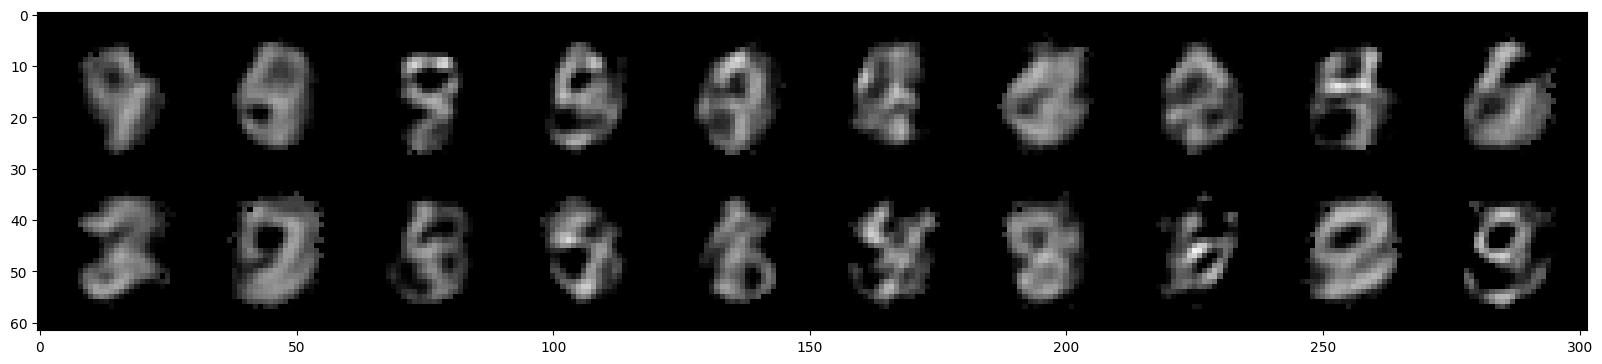

In [260]:
vae.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    for (images, labels) in test_dataloader:
        break
    images = images#.to(device)
    latent = vae.encode(images.reshape((batch_size, -1)))
    #latent = latent#.cpu()
    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(batch_size, latent_dim)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent#.to(device)
    img_recon = vae.decode(latent)
    img_recon = img_recon.reshape((batch_size, 1, 28, 28))#.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    im = make_grid(img_recon[:20], nrow=10)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    plt.show()

### Concept Check 2.3.4